Results saved to /Volumes/SP_SAGHAR/Documents/University/Articles/Conference/4- Elam o Farhang - Web/result/2/FL_TopK_Results.xlsx


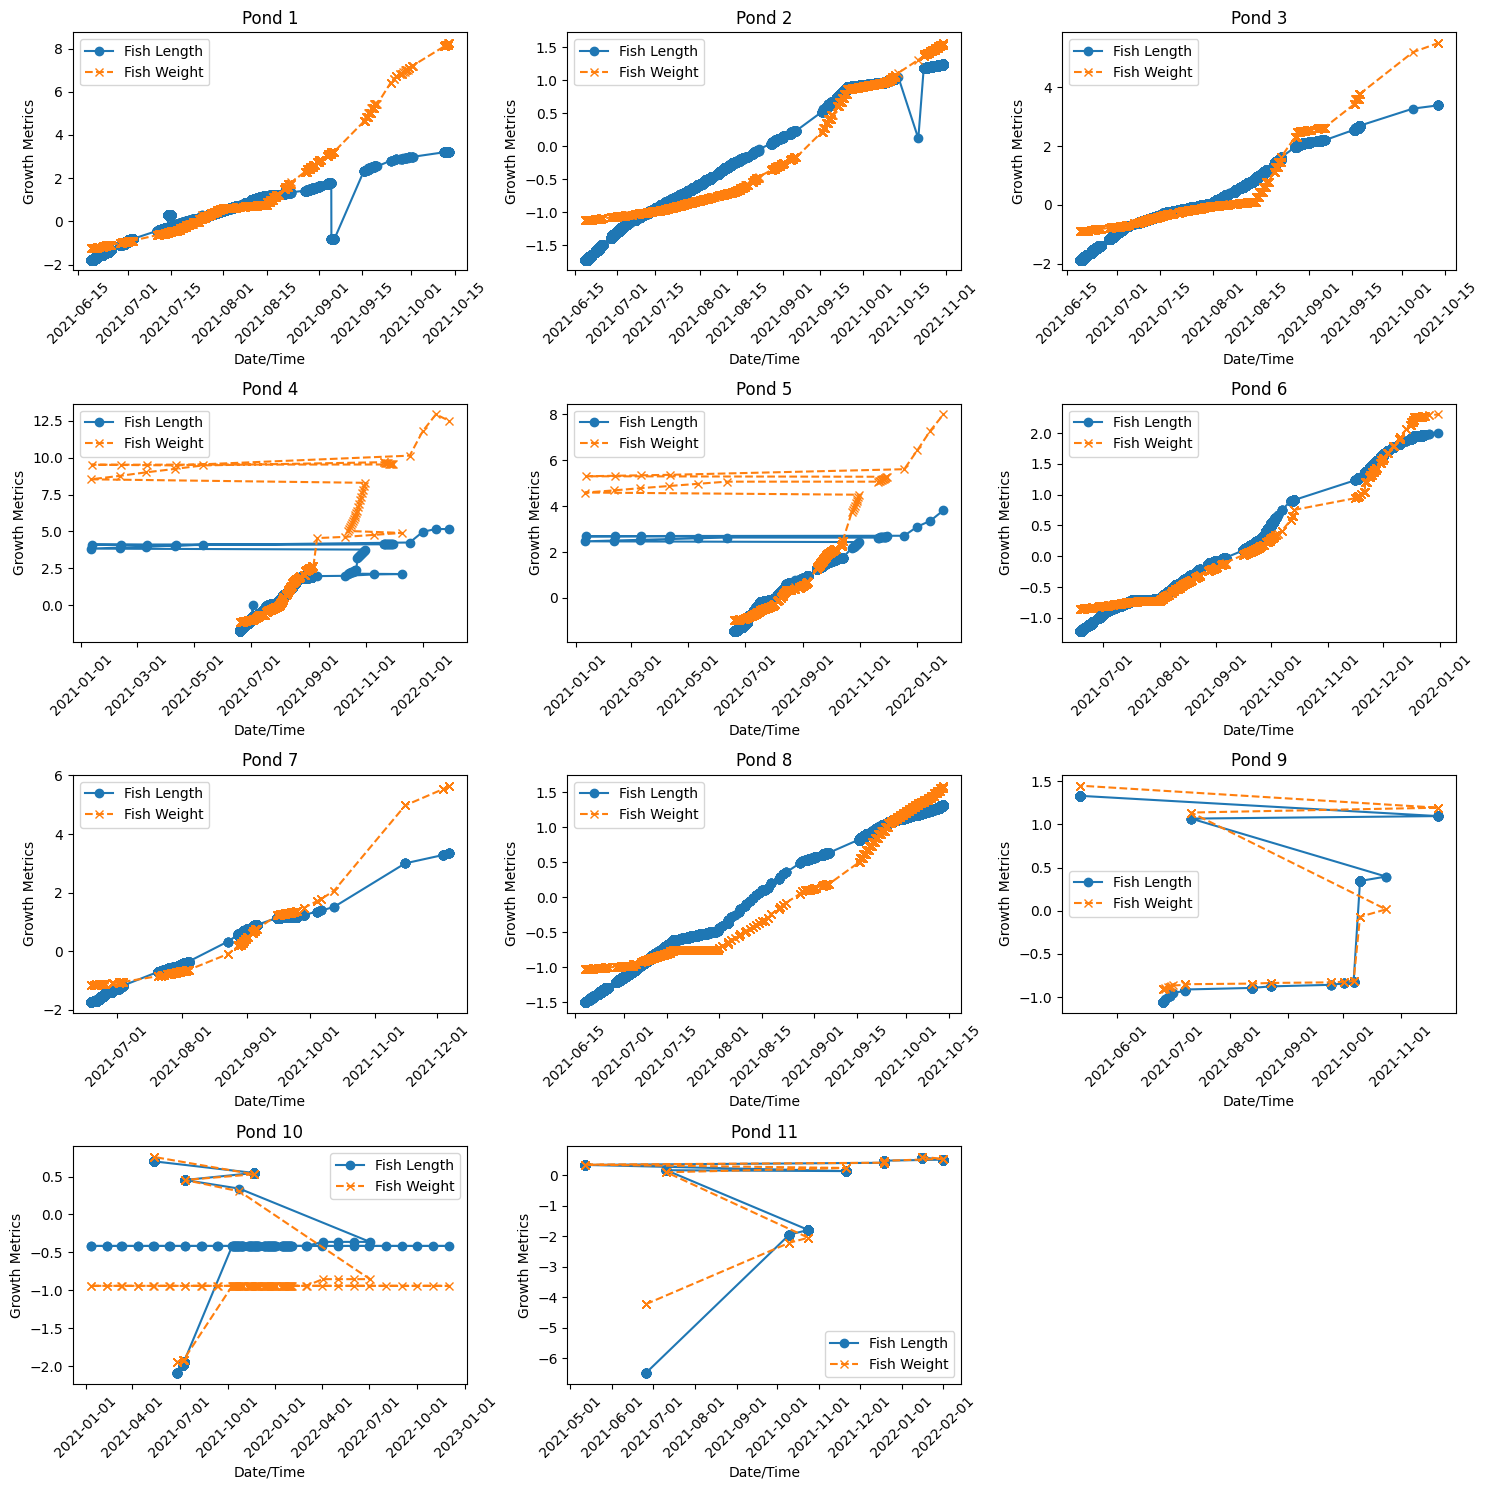

Time series visualization saved to /Volumes/SP_SAGHAR/Documents/University/Articles/Conference/4- Elam o Farhang - Web/result/2/Ponds_Time_Series.png


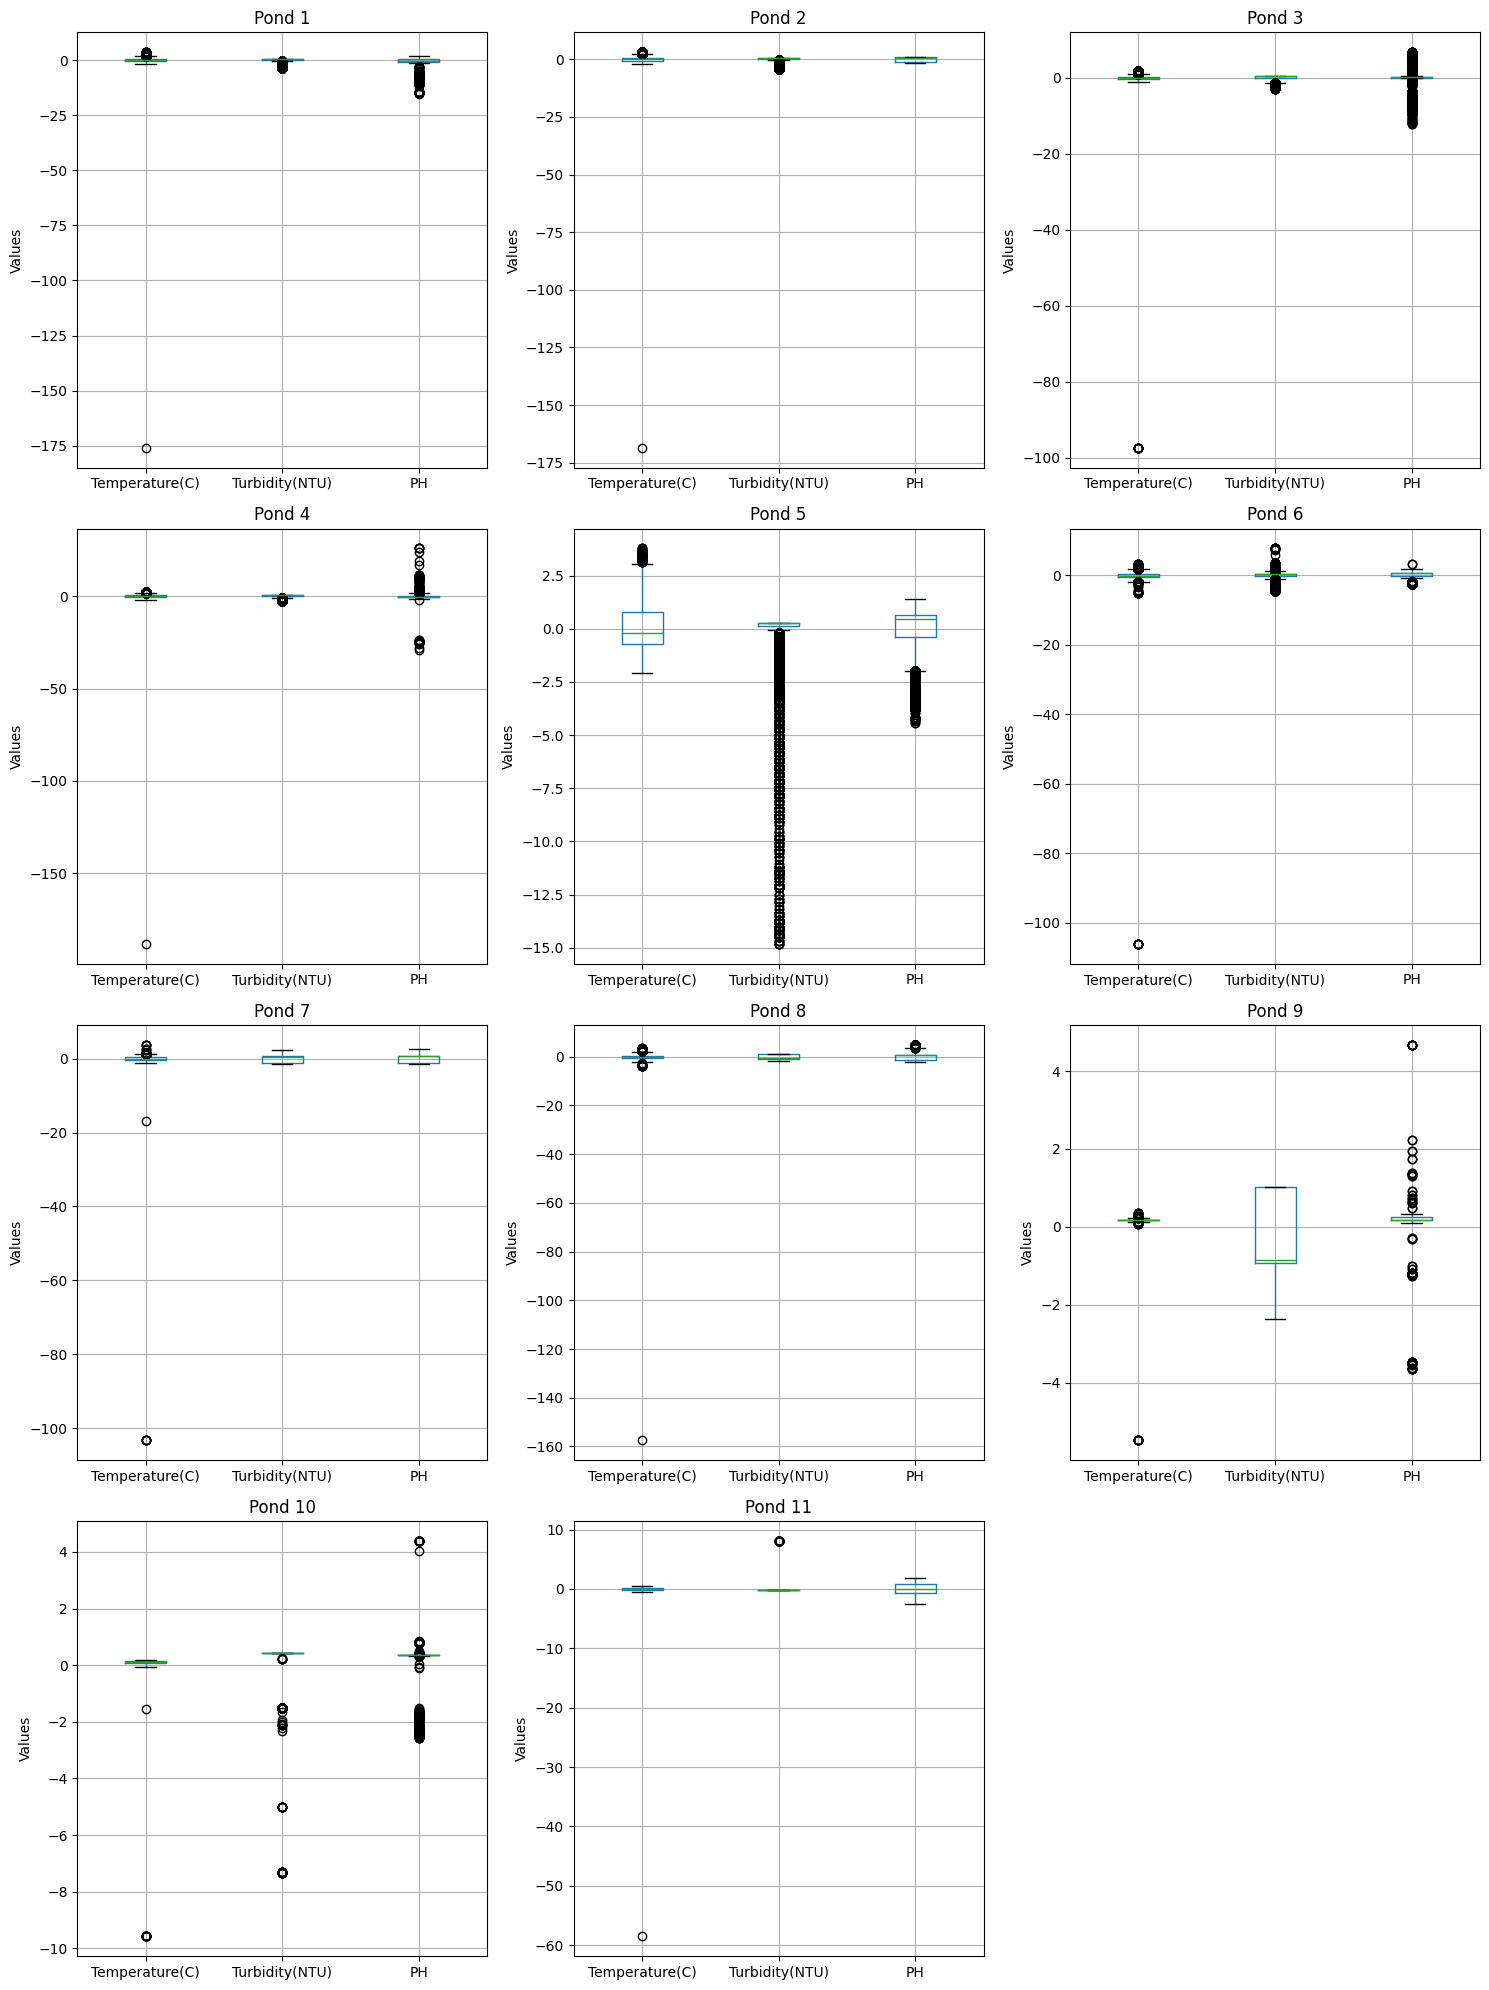

Boxplots saved to /Volumes/SP_SAGHAR/Documents/University/Articles/Conference/4- Elam o Farhang - Web/result/2/Ponds_Boxplots_Adjusted.png


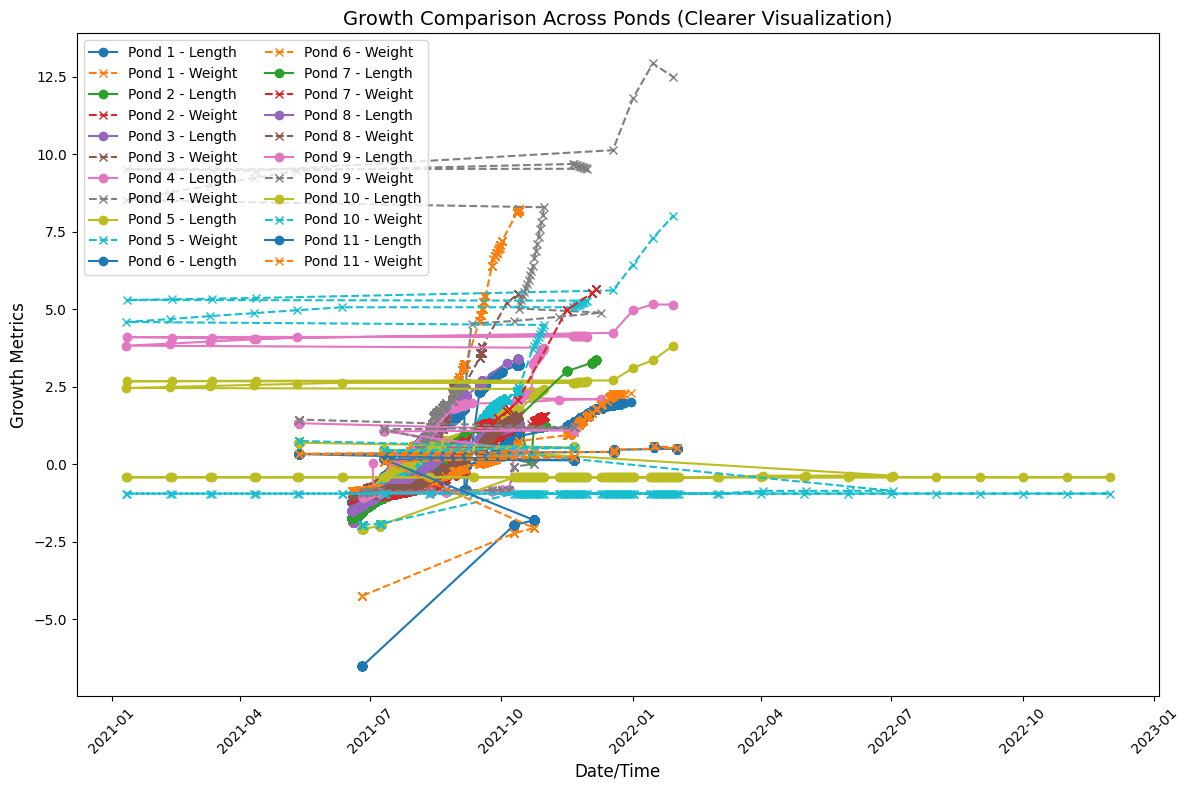

Growth comparison saved to /Volumes/SP_SAGHAR/Documents/University/Articles/Conference/4- Elam o Farhang - Web/result/2/Clearer_Growth_Comparison.png


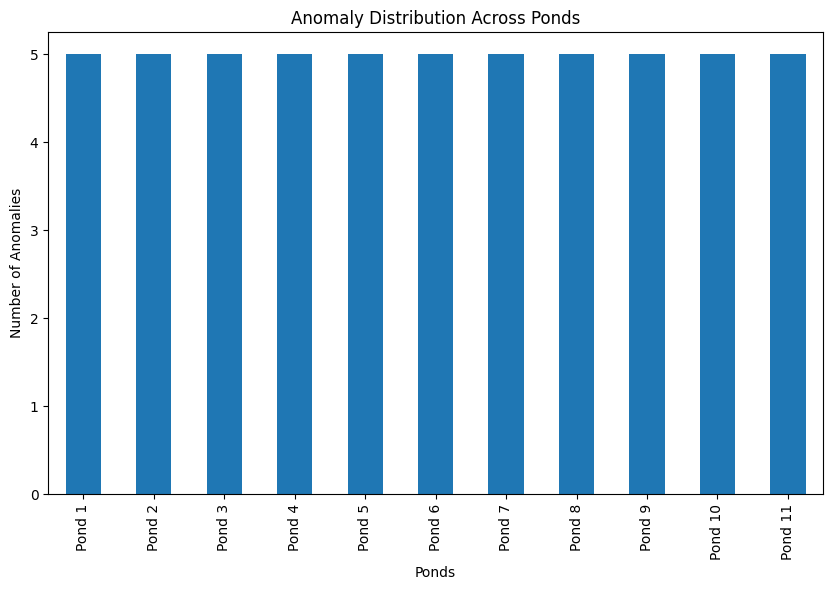

Anomaly distribution saved to /Volumes/SP_SAGHAR/Documents/University/Articles/Conference/4- Elam o Farhang - Web/result/2/Anomaly_Distribution.png


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/threadpoolctl.py:1019: RuntimeWarning: libc not found. The ctypes module in Python 3.8 is maybe too old for this OS.
  warnings.warn(


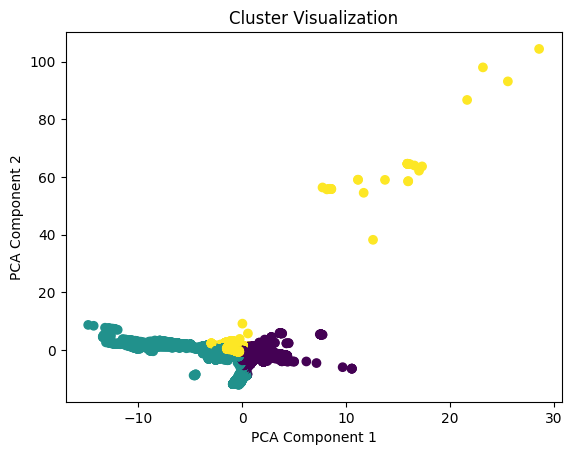

Cluster visualization saved to /Volumes/SP_SAGHAR/Documents/University/Articles/Conference/4- Elam o Farhang - Web/result/2/Cluster_Visualization.png
Evaluation metrics saved to /Volumes/SP_SAGHAR/Documents/University/Articles/Conference/4- Elam o Farhang - Web/result/2/Evaluation_TopK.xlsx
       Pond  Correlation  Patterns
0    Pond 1     0.899431         5
1    Pond 2     0.967312         5
2    Pond 3     0.913650         5
3    Pond 4     0.957270         5
4    Pond 5     0.962543         5
5    Pond 6     0.988584         5
6    Pond 7     0.965693         5
7    Pond 8     0.981434         5
8    Pond 9     0.979886         5
9   Pond 10     0.994046         5
10  Pond 11     0.975168         5


In [1]:
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from concurrent.futures import ThreadPoolExecutor
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter, AutoDateLocator
from dateutil import parser, tz
import warnings
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import warnings
import seaborn as sns
import heapq

# Suppress warnings
warnings.filterwarnings("ignore", message="UnknownTimezoneWarning")

# Paths
DATA_PATH = "your_path"
RESULT_PATH = "your_path"

# Filenames
file_names = [f"IoTpond{i}.csv" for i in range(1, 13) if i != 5]  # Exclude Pond 5

# Define timezone mapping for CET
tzinfos = {"CET": tz.gettz("CET")}

# Load and preprocess data
def load_and_preprocess_data(file_names, data_path):
    datasets = []
    scaler = StandardScaler()

    for file_name in file_names:
        file_path = os.path.join(data_path, file_name)
        try:
            data = pd.read_csv(file_path, low_memory=False)
        except Exception as e:
            print(f"Error loading {file_name}: {e}")
            continue

        # Validate necessary columns
        required_columns = ['Date/Time', 'Temperature(C)', 'Turbidity(NTU)', 'Dissolved Oxygen(g/ml)',
                            'PH', 'Ammonia(g/ml)', 'Nitrate(g/ml)', 'Population', 'Fish_Length(cm)', 'Fish_Weight(g)']
        if not all(col in data.columns for col in required_columns):
            print(f"Skipping {file_name}: Missing required columns.")
            continue

        # Parse Date/Time and handle timezone
        try:
            data['Date/Time'] = data['Date/Time'].apply(
                lambda x: parser.parse(x, tzinfos=tzinfos).replace(tzinfo=None) if pd.notna(x) else None
            )
            data.dropna(subset=['Date/Time'], inplace=True)
        except Exception as e:
            print(f"Error parsing datetime in {file_name}: {e}")
            continue

        # Convert all required columns to numeric
        for col in required_columns[1:]:
            data[col] = pd.to_numeric(data[col], errors='coerce')

        # Replace invalid values and handle missing data
        data.replace([np.inf, -np.inf], np.nan, inplace=True)
        for col in required_columns[1:]:
            if data[col].isna().sum() > 0:
                data[col].fillna(data[col].median(), inplace=True)

        # Scale features
        try:
            data[required_columns[1:]] = scaler.fit_transform(data[required_columns[1:]])
        except ValueError as e:
            print(f"Error scaling features in {file_name}: {e}")
            continue

        # Ensure dataset has enough rows
        if data.shape[0] < 5:  # Minimum 5 rows
            print(f"Skipping {file_name}: Insufficient data after cleaning ({data.shape[0]} rows).")
            continue

        datasets.append(data)

    if len(datasets) == 0:
        print("No valid datasets found. Please check your data files.")
        return []

    return datasets

datasets = load_and_preprocess_data(file_names, DATA_PATH)

if len(datasets) == 0:
    raise ValueError("No valid datasets were loaded. Check your CSV files for errors.")

# Local anomaly detection using Top-K Mining
def detect_top_k_patterns(data, k=5):
    # Convert continuous features to discrete bins for rule mining
    binned_data = data.copy()
    for col in ['Temperature(C)', 'Turbidity(NTU)', 'Dissolved Oxygen(g/ml)',
                'PH', 'Ammonia(g/ml)', 'Nitrate(g/ml)', 'Population']:
        binned_data[col] = pd.qcut(binned_data[col], q=4, labels=False, duplicates='drop')

    # Count patterns (combinations of feature-value pairs)
    pattern_counts = {}
    for _, row in binned_data.iterrows():
        transaction = tuple((f"{col}={val}") for col, val in row.items())
        for item in transaction:
            if item in pattern_counts:
                pattern_counts[item] += 1
            else:
                pattern_counts[item] = 1

    # Extract top-k patterns based on counts
    top_k_patterns = heapq.nlargest(k, pattern_counts.items(), key=lambda x: x[1])

    # Convert to DataFrame for easier analysis
    top_k_df = pd.DataFrame(top_k_patterns, columns=["Pattern", "Support"])
    return top_k_df

# Perform federated learning across ponds using parallelization
def federated_learning_parallel(datasets, k=5):
    global_patterns = pd.DataFrame()

    def process_pond(data, pond_index):
        top_k_patterns = detect_top_k_patterns(data, k=k)
        top_k_patterns["Pond"] = f"Pond {pond_index + 1}"
        return top_k_patterns

    with ThreadPoolExecutor() as executor:
        results = list(executor.map(lambda x: process_pond(x[1], x[0]), enumerate(datasets)))

    for top_k_patterns in results:
        global_patterns = pd.concat([global_patterns, top_k_patterns], ignore_index=True)

    return global_patterns

# Save results to Excel
def save_results_to_excel(patterns, datasets):
    os.makedirs(RESULT_PATH, exist_ok=True)
    output_file = os.path.join(RESULT_PATH, "FL_TopK_Results.xlsx")

    with pd.ExcelWriter(output_file) as writer:
        patterns.to_excel(writer, sheet_name="Global Patterns", index=False)

        for i, data in enumerate(datasets):
            data.to_excel(writer, sheet_name=f"Pond {i + 1}", index=False)

    print(f"Results saved to {output_file}")

# Visualization
def plot_all_visualizations(datasets, global_patterns):
    # Time Series
    fig, axs = plt.subplots(nrows=4, ncols=3, figsize=(15, 15))
    axs = axs.flatten()

    for i, data in enumerate(datasets):
        axs[i].plot(data['Date/Time'], data['Fish_Length(cm)'], label="Fish Length", linestyle='-', marker='o')
        axs[i].plot(data['Date/Time'], data['Fish_Weight(g)'], label="Fish Weight", linestyle='--', marker='x')
        axs[i].set_title(f"Pond {i + 1}")
        axs[i].set_xlabel("Date/Time")
        axs[i].set_ylabel("Growth Metrics")
        axs[i].xaxis.set_major_locator(AutoDateLocator())
        axs[i].xaxis.set_major_formatter(DateFormatter("%Y-%m-%d"))
        axs[i].tick_params(axis="x", rotation=45)
        axs[i].legend()

    for j in range(len(datasets), len(axs)):
        fig.delaxes(axs[j])

    plt.tight_layout()
    plot_path = os.path.join(RESULT_PATH, "Ponds_Time_Series.png")
    plt.savefig(plot_path)
    plt.show()
    print(f"Time series visualization saved to {plot_path}")

    # Boxplots
    num_datasets = len(datasets)
    rows = (num_datasets + 2) // 3
    fig, axs = plt.subplots(nrows=rows, ncols=3, figsize=(15, 5 * rows))
    axs = axs.flatten()

    for i, data in enumerate(datasets):
        data[['Temperature(C)', 'Turbidity(NTU)', 'PH']].boxplot(ax=axs[i])
        axs[i].set_title(f"Pond {i + 1}")
        axs[i].set_ylabel("Values")

    for j in range(num_datasets, len(axs)):
        fig.delaxes(axs[j])

    plt.tight_layout()
    plot_path = os.path.join(RESULT_PATH, "Ponds_Boxplots_Adjusted.png")
    plt.savefig(plot_path)
    plt.show()
    print(f"Boxplots saved to {plot_path}")

# Evaluate relationship between anomalies and growth
def evaluate_anomalies_and_growth(global_patterns, datasets):
    results = []

    for i, data in enumerate(datasets):
        patterns = global_patterns[global_patterns["Pond"] == f"Pond {i + 1}"]
        correlation = data[["Fish_Length(cm)", "Fish_Weight(g)"]].corr()
        results.append({"Pond": f"Pond {i + 1}", "Correlation": correlation.iloc[0, 1], "Patterns": len(patterns)})

    evaluation_df = pd.DataFrame(results)
    evaluation_path = os.path.join(RESULT_PATH, "Evaluation_PrefixSpan.xlsx")
    evaluation_df.to_excel(evaluation_path, index=False)
    print(f"Evaluation metrics saved to {evaluation_path}")
    return evaluation_df

# Main Execution
def main():
    global_patterns = federated_learning_parallel(datasets, k=5)  # Updated argument to 'k' for Top-K Mining
    save_results_to_excel(global_patterns, datasets)

    # Generate and save all visualizations
    plot_all_visualizations(datasets, global_patterns)

    # Evaluate and save metrics
    evaluation_df = evaluate_anomalies_and_growth(global_patterns, datasets)
    print(evaluation_df)

# Ensure datasets are loaded
if 'datasets' not in locals() or not datasets:
    raise ValueError("Datasets not loaded. Ensure data preprocessing is complete before running the main script.")

if __name__ == "__main__":
    main()